['GRBALPHA_20241017T082528_pickled.bin', 'GRBALPHA_20241017T224535_pickled.bin', 'GRBALPHA_20241018T001903_pickled.bin', 'GRBALPHA_20241018T110034_pickled.bin', 'GRBALPHA_20241018T221326_pickled.bin', 'GRBALPHA_20241018T234627_pickled.bin', 'GRBALPHA_20241019T085324_pickled.bin', 'GRBALPHA_20241019T102657_pickled.bin', 'GRBALPHA_20241019T214126_pickled.bin', 'GRBALPHA_20241020T224123_pickled.bin', 'GRBALPHA_20241022T230911_pickled.bin', 'GRBALPHA_20241023T094901_pickled.bin', 'GRBALPHA_20241024T105037_pickled.bin', 'GRBALPHA_20241025T230331_pickled.bin', 'GRBALPHA_20241026T223029_pickled.bin', 'GRBALPHA_20241027T000340_pickled.bin', 'GRBALPHA_20241027T233012_pickled.bin', 'GRBALPHA_20241028T083709_pickled.bin', 'GRBALPHA_20241028T100958_pickled.bin', 'GRBALPHA_20241028T225645_pickled.bin', 'GRBALPHA_20241029T003018_pickled.bin', 'GRBALPHA_20241030T090242_pickled.bin', 'GRBALPHA_20241030T103630_pickled.bin', 'GRBALPHA_20241030T232232_pickled.bin', 'GRBALPHA_20241031T005632_pickled.bin',

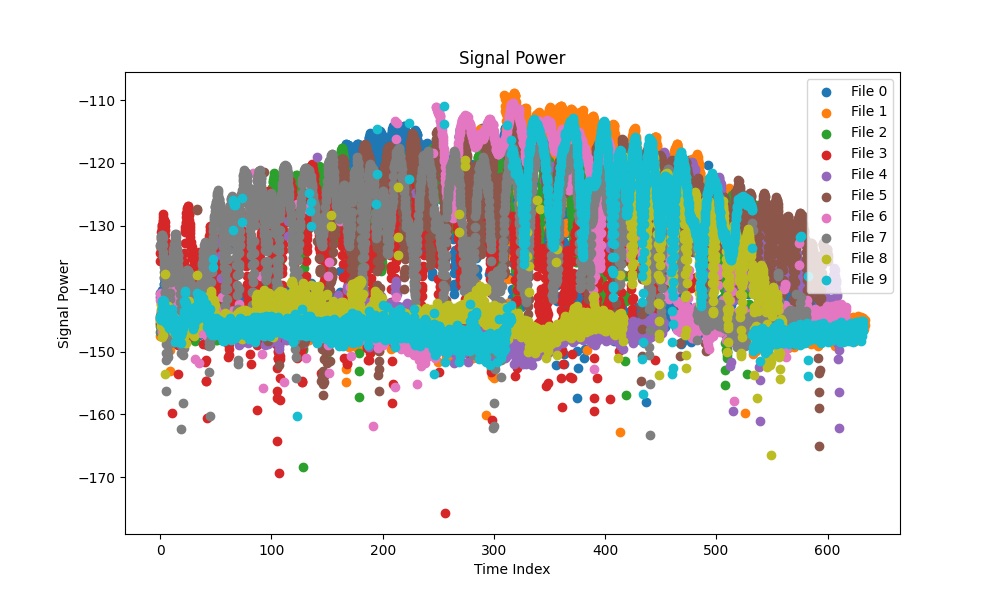

In [36]:
%matplotlib widget
#remember to pip install ipympl
import matplotlib.pyplot as plt
import noisy_moose as nm  # Ensure noisy_moose is installed
import json
import pickle
import numpy as np
import os


# Define the data path
data_path = 'C:/Users/StoreElberg/OneDrive - Aalborg Universitet/Git3/no_waterfall/active/'
data_path = "C:/Users/asbjo/OneDrive/Dokumenter/GitHub/no_waterfall/active/"

# Get all files in the directory
files = os.listdir(data_path)

# Filter files starting with 'GRBALPHA'
files = [f for f in files if f.startswith('GRBALPHA')]

# Print the filtered files
print(files)

def calculate_pointing_error(set_azimuth, set_elevation, azimuth, elevation):
    """
    Calculate the pointing error given reference (set) and measured azimuth and elevation.
    
    Parameters:
        set_azimuth (array-like): Reference azimuth values in degrees.
        set_elevation (array-like): Reference elevation values in degrees.
        azimuth (array-like): Measured azimuth values in degrees.
        elevation (array-like): Measured elevation values in degrees.
    
    Returns:
        np.ndarray: Pointing error for each pair of reference and measured angles in degrees.
    """
    # Convert degrees to radians
    set_azimuth_rad = np.radians(set_azimuth)
    set_elevation_rad = np.radians(set_elevation)
    azimuth_rad = np.radians(azimuth)
    elevation_rad = np.radians(elevation)
    
    # Compute the pointing error using the great-circle distance formula
    pointing_error_rad = np.arccos(
        np.sin(set_elevation_rad) * np.sin(elevation_rad) +
        np.cos(set_elevation_rad) * np.cos(elevation_rad) * np.cos(azimuth_rad - set_azimuth_rad)
    )
    
    # Convert the pointing error back to degrees
    pointing_error_deg = np.degrees(pointing_error_rad)
    return pointing_error_deg

def unpickle(file):
    """Unpickles the given file from data_path."""
    try:
        with open(data_path + file, 'rb') as f:
            dump = f.read()
        return pickle.loads(dump)
    except FileNotFoundError:
        print(f"File {file + '_pickled.bin'} not found. Skipping.")
        return None

def extract_features(prop_obj):
    """Extract multiple features from the given object."""
    if prop_obj is None:
        return None  # Skip if object is None

    # Calculate features
    pointing_error = calculate_pointing_error(
        prop_obj.station_obj.set_azimuth, 
        prop_obj.station_obj.set_elevation, 
        prop_obj.station_obj.azimuth, 
        prop_obj.station_obj.elevation
    )
    corrected_power = 10 * np.log10(prop_obj.noise_obj.signal_abs) - prop_obj.station_obj.fspl

    # Features
    features = [
        prop_obj.time_ax,                  # Time (0)
        prop_obj.noise_obj.signal_abs,     # Signal Power (1)
        prop_obj.station_obj.fspl,         # FSPL (2)
        prop_obj.station_obj.dist,         # Distance (3)
        prop_obj.station_obj.set_azimuth,  # Target azimuth (4)
        prop_obj.station_obj.set_elevation,# Target elevation (5)
        pointing_error,                    # Pointing error (6)
        prop_obj.noise_obj.noise,          # Noise power in W/Hz (7)
        corrected_power,                   # FSPL corrected signal power (8)
    ]

    # Find the maximum length
    max_length = max(len(feature) for feature in features)

    # Pad all features to the maximum length
    padded_features = [
        np.pad(feature, (0, max_length - len(feature)), constant_values=np.nan)
        for feature in features
    ]

    # Stack features column-wise
    return np.vstack(padded_features)


# Collect and process data
data_list = []
for f in files[:30]:  # Go through all files
    data: nm.prepping = unpickle(f)
    if data is not None:
        features = extract_features(data)
        if features is not None:
            data_list.append(features)

# Determine maximum length for padding
max_length = max(features.shape[1] for features in data_list)

# Pad the data for each file
padded_data = [
    np.pad(features, ((0, 0), (0, max_length - features.shape[1])), constant_values=np.nan) #all the ones which are not long enough are padded with nan, not ZERO or interpolated.
    for features in data_list
]

# Convert to a 3D numpy array: (file index, feature index, time index)
BAM = np.array(padded_data, dtype=np.float32)
print(f"BAM shape: {BAM.shape} (files, features, time)")

# Plot the first feature (e.g., signal power) for all files
plt.figure(figsize=(10, 6))
# for i in range(BAM.shape[0]):
for i in range(10):
    plt.scatter(BAM[i, 0], 10*np.log10(BAM[i, 1]), label=f'File {i}')  # Plot Feature 2 (Signal Power)
plt.xlabel('Time Index')
plt.ylabel('Signal Power')
plt.title('Signal Power')
plt.legend()
plt.show()

In [38]:
MOVBAM = []  # Initialize as an empty list
for i in range(BAM.shape[0]):
    # Compute moving average of the signal power
    # Define the moving average window size
    window_size = 100

    # Pad the signal symmetrically with NaNs (or a constant like -130 to match your data)
    padded_signal = np.pad(10 * np.log10(BAM[i, 1, :]), (50, 49), mode='constant', constant_values=np.nan)

    # Perform convolution in 'valid' mode
    moving_avg = np.convolve(padded_signal, np.ones(window_size)/window_size, mode='valid')

    # moving_avg = np.convolve(10*np.log10(BAM[i, 1, :]), np.ones(100)/100, mode='valid')
    # moving_avg = np.convolve(10*np.log10(BAM[i, 1, :]), np.ones(100)/100, mode='valid')
    MOVBAM.append(moving_avg)  # Append the result to the list
    # plt.figure()
    # plt.plot(moving_avg, label=f'MOV {i}')
    # plt.plot(10*np.log10(BAM[i, 1, :]), label=f'BAM {i}')
    # plt.xlabel('Time Index')
    # plt.legend()
    # plt.show()


# Convert MOVBAM to a numpy array for easier manipulation
MOVBAM = np.array(MOVBAM)

# Print the shape of MOVBAM
print(f"MOVBAM shape: {MOVBAM.shape}")
print(f"BAM shape: {BAM.shape[2]}")

print(MOVBAM)
# mask = MOVBAM[:,:] < 10**(-138/10)
mask = MOVBAM[:,:] < -140
print(mask)
# Add a new column to BAM based on the mask
new_column = np.where(mask, np.nan, 1)  # Set to NaN where mask is True, otherwise 1
# Pad the mask to the length of BAM.shape[2] with False values
padded_mask = np.pad(mask, ((0, 0), (0, BAM.shape[2] - mask.shape[1])), constant_values=True)

# Check the shape of the mask
print(f"Mask shape: {padded_mask.shape}")
print(f"BAM shape: {BAM.shape}")

# Expand the mask to match BAM dimensions (broadcast over the features dimension)
expanded_mask = np.expand_dims(padded_mask, axis=1)  # Shape becomes [file, 1, index]
expanded_mask = np.repeat(expanded_mask, BAM.shape[1], axis=1)  # Repeat over features dimension

# Set all points in BAM to NaN where the mask is True
BAM[expanded_mask] = np.nan

# Print confirmation
print(f"Modified BAM with NaN applied based on the mask.")

MOVBAM shape: (30, 3176)
BAM shape: 3176
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Mask shape: (30, 3176)
BAM shape: (30, 9, 3176)
Modified BAM with NaN applied based on the mask.


# Threshold

In [3]:
threshold=10**(-138/10) #-138dBm
print(threshold)
for file_idx in range(BAM.shape[0]):
    signal_power = BAM[file_idx, 1, :]  # Signal power is at feature index 1

    # Identify time indices where signal power is below the threshold
    mask = signal_power < threshold

    # Set all features at these time indices to NaN for the current file
    BAM[file_idx, :, mask] = np.nan

1.584893192461111e-14


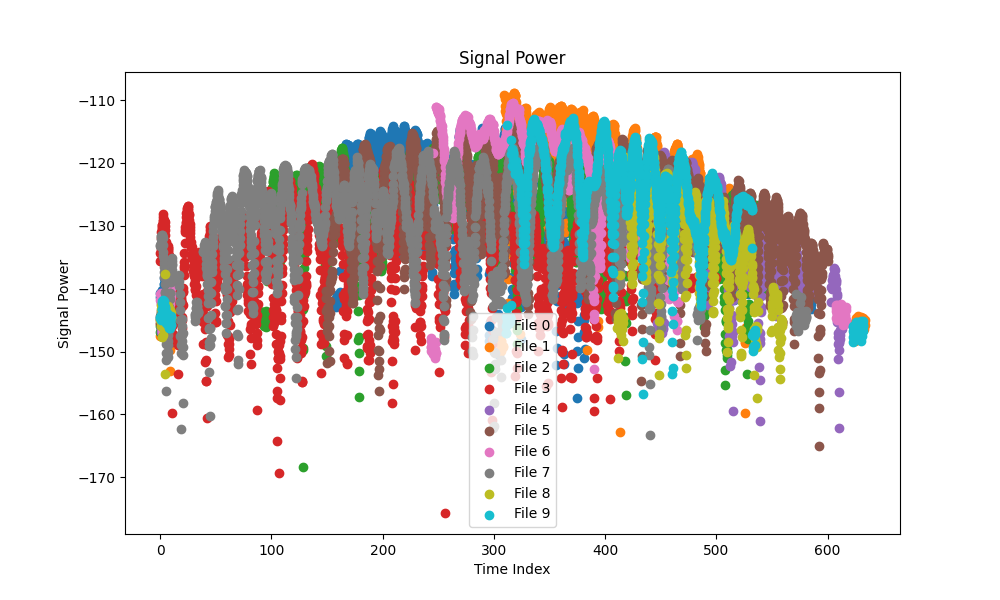

In [39]:
# Plot the first feature (e.g., signal power) for all files
plt.figure(figsize=(10, 6))
# for i in range(BAM.shape[0]):
for i in range(10):
    plt.scatter(BAM[i, 0], 10*np.log10(BAM[i, 1]), label=f'File {i}')  # Plot Feature 2 (Signal Power)
plt.xlabel('Time Index')
plt.ylabel('Signal Power')
plt.title('Signal Power')
plt.legend()
plt.show()

Shape of all valid samples combined: (9, 50129)


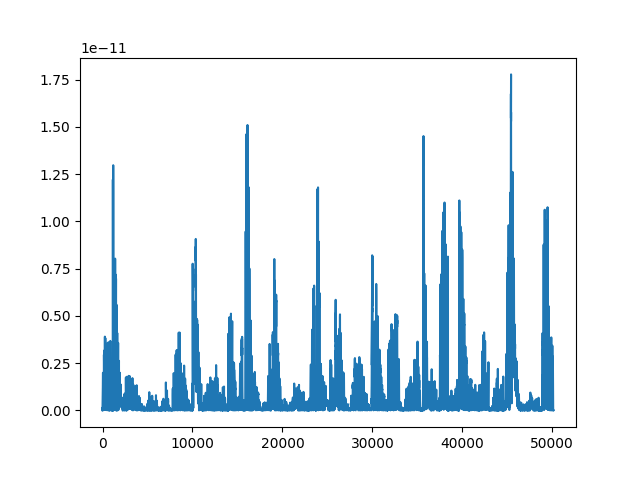

In [74]:

import numpy as np
import matplotlib.pyplot as plt

def extract_largest_non_nan_chunk(data):
    """
    Extracts the largest continuous block of non-NaN rows from a 2D array (samples x features),
    where each row is either fully valid or fully NaN.
    
    Args:
        data (numpy.ndarray): 2D array representing satellite pass data (features x samples).
        
    Returns:
        numpy.ndarray: Largest contiguous block of non-NaN rows from the input data,
                       or an empty array if no valid rows exist.
    """
    # Identify columns (samples) that are completely free of NaNs across all features (rows)
    non_nan_mask = ~np.isnan(data).any(axis=0)
    
    # If no valid samples exist, return an empty array with the correct feature dimensions
    if not np.any(non_nan_mask):
        return np.empty((data.shape[0], 0))  # Return empty array with the same number of features
    
    # Identify contiguous True regions in non_nan_mask (valid samples)
    starts = np.where(np.diff(np.concatenate([[0], non_nan_mask, [0]])) == 1)[0]
    ends = np.where(np.diff(np.concatenate([[0], non_nan_mask, [0]])) == -1)[0]
    
    # Find the largest contiguous block
    largest_chunk_idx = np.argmax(ends - starts)
    start_index = starts[largest_chunk_idx]
    end_index = ends[largest_chunk_idx]
    
    # # Visualize the data
    # plt.figure()
    # plt.plot(data[1][:])  # Plot the second feature (index 1) across all samples
    # plt.plot(data[1][start_index:end_index])  # Plot the segment of the largest contiguous block
    # plt.show()

    # print(f"Data shape: {data.shape} -vs- Extracted chunk shape: {data[:, start_index:end_index].shape}")
    
    # Extract and return the largest contiguous block (all features for the valid samples)
    # print(type(data[:, start_index:end_index]))
    return data[:, start_index:end_index]




largest_chunks = []
for satellite_pass in BAM:
    largest_chunk = extract_largest_non_nan_chunk(satellite_pass)
    largest_chunks.append(largest_chunk)


# Now we want to concatenate all the largest chunks horizontally (axis=1)
# First, ensure that all chunks are of shape (9, n), so we can concatenate them
# Use np.hstack to stack the chunks horizontally
valid_chunks = [chunk for chunk in largest_chunks if chunk.shape[0] > 0]  # Only keep non-empty chunks

if valid_chunks:
    # Concatenate all valid chunks along axis 1
    all_valid_samples = np.hstack(valid_chunks)  # This will combine the chunks (9, total_samples)
    print(f"Shape of all valid samples combined: {all_valid_samples.shape}")
else:
    print("No valid chunks found.")
# # Convert back to an array
# BAM_strip = np.array(largest_chunks, dtype=object)
# print("Shape of nan stripped BAM:", BAM_strip.shape)

# Visualize the data
plt.figure()
plt.plot(all_valid_samples[1][:])  # Plot the second feature (index 1) across all samples
plt.show()




Shape of dataset: (9, 50129)
Mean Squared Error on the test set: 0.0000
Actual values: [5.4059068e-13 9.9590536e-14 1.8961487e-13 4.9859964e-14 6.9266524e-12]
Predicted values: [6.57878795e-13 3.63251585e-13 4.27823390e-13 3.32529473e-13
 4.76141243e-12]


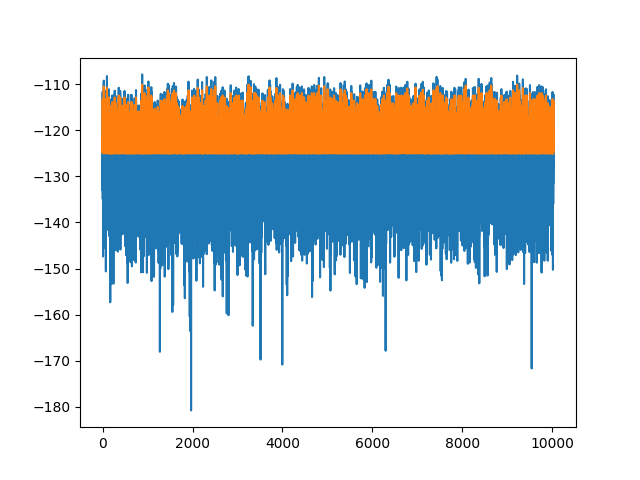

In [80]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor

# Assuming all_valid_samples is your data array with shape (9, 50129)
print(f"Shape of dataset: {all_valid_samples.shape}")

# Flatten the data into a 2D array where each sample is a row
# Transpose it so we have shape (50129, 9) for samples and features
X = all_valid_samples.T  # Shape: (50129, 9)

# Extract the target variable (signal power or whatever your target is)
# For example, let's assume we want to predict the signal power (feature 1)
# You can adjust the target variable to suit your problem
y = X[:, 1]  # Let's assume we're predicting the second feature, i.e., signal power

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the regression model
model = HistGradientBoostingRegressor()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model (using mean squared error)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the test set: {mse:.4f}")

# Optionally, you can also print the predictions and compare with the actual values
print(f"Actual values: {y_test[:5]}")
print(f"Predicted values: {y_pred[:5]}")

plt.figure()
# plt.plot(y_test)
# plt.plot(y_pred)
plt.plot(10*np.log10(y_test))
plt.plot(10*np.log10(y_pred))
plt.show()



